# Twin Events Processor
  
**Requirements**: Twin events file .docx in the participant's folder, named according to processing documentation  
**Input**: .docx mentioned above  
**Output**:
1. .csv (if export=True) of the correct sequence of events as well as each event's point latency to be used in BrainVision Analyzer
2. .csv (if export=True) of any corrections that were made to the sequence of events

# Import packages

In [1]:
# for finding the right file and manipulating datetime objects
import glob
from datetime import timedelta
import csv

# for data structures and tools
import numpy as np
import pandas as pd

# for making plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# for reading microsoft word files
import docx

# Initial Editable Parameters

In [2]:
# Edit this to match the participant number
participant_num = 2
sart_sequence = 'A'

# Export? set to True to save output as csv
export = True

# Initial Setup for Processing

In [3]:
# These are the values coded for events
start_val = '100'
end_val = '101'
stim_val = '20'
block_val = '30'
break_val = '40'

pathdict = {'pNum': participant_num, 'seq': sart_sequence}
base_path = 'X:/PROJECTS/14. Waking States and Memory/Data/'

# Create a dataframe containing the correct sequence of events. We want to remove the break_val's because they are not
# logged to twin, only to the eyetracker log
correct_seq = pd.DataFrame.from_csv(path= base_path + 'correct_seq.csv')
seqCol = 'seq' + sart_sequence
correct_seq[seqCol] = correct_seq[seqCol].astype(str)
correct_seq = correct_seq.loc[correct_seq[seqCol] != break_val,].reset_index(drop=True)

# This is the path of the event file to be analyzed
participant_path = base_path + '%(pNum)02d' % pathdict
docx_path = glob.glob(participant_path + '/%(pNum)02devents%(seq)s[SI].docx' % pathdict)[0]
print('ANALYZING FILE: ' + docx_path)

ANALYZING FILE: X:/PROJECTS/14. Waking States and Memory/Data/02\02eventsAS.docx


In [4]:
# These two arrays will store the timestamp and event value for each event
time_array = []
event_array = []

# Open the event Microsoft word document
doc = docx.Document(docx_path)

# Read each line extracing the time and event from each line
for line in doc.paragraphs:
    if not line.text:
        continue
    else:
        temp_cols = line.text.split(',')
        try:
            time_array.append(temp_cols[1])
            event_array.append(temp_cols[2])
        except IndexError:
            print("There is a problem with the event docx file.\nOpen it in Word and delete any funky characters at the end of the document")
            raise Exception("FIX THIS BEFORE CONTINUING")
        
#Make sure the number of events is equal to the number of times
if len(time_array) != len(event_array):
    raise Exception('The number of times and events is not equal! Check the Word doc.')

# Make a dataframe out of the event and time data from the word doc
event_data = {'time': time_array, 'event': event_array}
event_df = pd.DataFrame(data=event_data)
event_df.time = pd.to_datetime(event_df.time.map(str.strip))

# Get the time at event 'Start Recording'. Used later to calculate latency
if event_df.loc[0, 'event'] == 'Start Recording':
    eeg_start_recording = event_df.loc[0, 'time']
else:
    ex = "The first event isn't 'Start Recording'. Check the event word doc./nIf there is some other event that comes before it, remove it from the word doc.\nIf 'Start Recording' is missing entirely, try reexporting from TWin."
    raise Exception("The first event isn't 'Start Recording'...")

# Remove rows that arent events (events that are not numbers, eg 'New Montage', 'Start Recording', etc...)
event_df = event_df[~event_df.event.str.contains(r'\D')]
event_df = event_df.reset_index(drop=True)

# Add a column, 'estimated', to indicate whether an event was missing and had to be inserted/estimated
event_df['estimated'] = False

## Correction Functions

In [5]:
def insertStartEvent(df):
    new_time = df.get_value(0, 'time')
    prepended_df = pd.DataFrame([[int(start_val), new_time, True]], columns=['event', 'time', 'estimated'])
    df = pd.concat([prepended_df, df])
    df = df.reset_index(drop=True)
    
    log_start_missing = True
    
    return df

def insertNewEvent(df, new_val_index, new_val):
    temp_upper = df.loc[0:new_val_index-1]
    temp_lower = df.loc[new_val_index:]
    if new_val == block_val:
        new_time = df.get_value(new_val_index, 'time') - timedelta(milliseconds=600)
    else:
        new_time = df.get_value(new_val_index-1, 'time')
    new_row = pd.DataFrame([[new_val, new_time, True]], columns=['event', 'time', 'estimated'])
    df = pd.concat([temp_upper, new_row, temp_lower])
    df = df.reset_index(drop=True)
    
    log_inserted_vals.append((new_val_index, new_val))
    
    return df

def completeTerminatedFile(df, early_end_index):
    log_num_of_events_appended = len(correct_seq) - early_end_index
    for j in range(early_end_index, len(correct_seq)):
        event_df.loc[j, 'event'] = correct_seq.loc[j, 'event']
        event_df.loc[j, 'estimated'] = True
    return event_df

# Variables used to track corrections made
log_start_missing = False
log_inserted_vals = []
log_drop_after = False
log_ends_early = False
log_num_of_events_appended = 0

## Check and Correct Events
Go through every event in the file and compare it to the correct sequence. If there is a mismatch, it will print it out and then correct it (if it knows how). Corrected/inserted events will equal True in the 'Estimated' column (because they were calculated and are not from the actual raw data.  
TODO: make sure the corrections are logged so the export will work properly.

In [6]:
# Don't edit anything here

block_location = 0
print("--------CHECKING AND EDITING--------")
for i in range(len(correct_seq)):
    try: event_df_cell = event_df.get_value(i, 'event')
    except KeyError:
        print('### MISMATCH ###')
        print('Current file terminates early')
        event_df = completeTerminatedFile(event_df, i)
        print("Fixed...")
        
    correct_event = correct_seq.get_value(i, seqCol)
    
    if event_df_cell == correct_event:
        if correct_event == block_val:
            block_location += 1
        continue
    else:
        print('### MISMATCH ###')
        if correct_event == start_val:
            print('Current file is missing the start event.')
            print("Current file shows %s when it should be %s." %(event_df_cell, correct_event))
            event_df = insertStartEvent(event_df)
            print('Fixed...')
        elif correct_event == block_val:
            print('Current file is missing a block event at index ' + str(i))
            print("Current file shows %s when it should be %s." %(event_df_cell, correct_event))
            event_df = insertNewEvent(event_df, i, block_val)
            print('Fixed...')
        elif correct_event == stim_val:
            print('Current file is missing a stimulus event at index ' + str(i))
            print("Current file shows %s when it should be %s." %(event_df_cell, correct_event))
            event_df = insertNewEvent(event_df, i, stim_val)
            print('Fixed...')
        else:
            print('UH OH. This is an error that is unaccounted for... Ted needs to fix this...')
            print('Here is some info about the error:')
            print("Incorrect event at index %d, in block %d" %(i, block_location))
            print("Current file shows %s when it should be %s." %(event_df.get_value(i, 'event'), correct_seq.get_value(i, seqCol)))
            print(event_df.loc[i-3:i+3, 'event'])
            print(correct_seq.loc[i-3:i+3, seqCol])
            break

# Check for extra events after the stop event and remove them
stop_index = event_df.loc[pd.to_numeric(event_df['event']) == 101].index.tolist()[0] # find the index of the stop event
rows_to_drop = range(stop_index+1,len(event_df.index)) # make an array from stop index to the end of the length of the df
# If there are rows to drop, drop them
if rows_to_drop:
    print('### ERROR ###')
    print('Current file had extra events after the stop event')
    event_df = event_df.drop(rows_to_drop)
    print('Fixed...')
    
    log_drop_after = True

print("------DONE CHECKING AND EDITING------")

--------CHECKING AND EDITING--------
------DONE CHECKING AND EDITING------


In [7]:
# Double check that everything is right
if sum(~correct_seq[seqCol].eq(event_df['event'])) > 0:
    raise Exception("Something went wrong with the correction process... Try rerunning from the top or reexporing the event file")

#View the new data frame
event_df

,event,time,estimated
0,100,2017-07-20 14:12:47.330,False
1,30,2017-07-20 14:12:47.950,False
2,20,2017-07-20 14:12:53.310,False
3,20,2017-07-20 14:12:59.030,False
4,20,2017-07-20 14:13:04.650,False
5,20,2017-07-20 14:13:10.510,False
6,20,2017-07-20 14:13:16.110,False
7,20,2017-07-20 14:13:21.710,False
8,20,2017-07-20 14:13:27.310,False
9,20,2017-07-20 14:13:33.110,False


# Calculate inter-event interval (IEI)

In [8]:
# Once the sequence has been verified correct, calculate the inter-event intervals in milliseconds. In the end only the
# stimulus events should have iei values, and all other should be NaN. Note that some will have very low times because
# it is calculating the time between the stimulus event and a block event which occur very close together
event_df.loc[:, 'iei'] = pd.to_numeric(event_df.time.diff(), errors='ignore')
event_df.loc[:, 'iei'] = event_df.loc[:, 'iei']/1000000
event_df.loc[event_df['event'] != stim_val, 'iei'] = np.nan

Max IEI:  5900.0
Min IEI:  1000.0
Mean IEI:  5324.738461538462
Median IEI:  5640.0


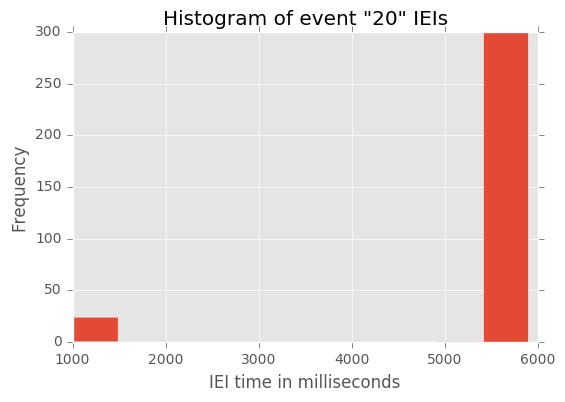

In [9]:
# Plot histogram of IEI well as some descriptive stuff
plt.figure()
plt.xlabel('IEI time in milliseconds')
plt.title('Histogram of event "%s" IEIs' %stim_val)
# includes the condition that iei>=1000 because we do not want to include the events that occured right after the block start indicator
event_df.loc[event_df.iei >= 1000, 'iei'].plot.hist()

print("Max IEI: ",event_df.loc[event_df.iei >= 1000, 'iei'].max())
print("Min IEI: ",event_df.loc[event_df.iei >= 1000, 'iei'].min())
print("Mean IEI: ",event_df.loc[event_df.iei >= 1000, 'iei'].mean())
print("Median IEI: ",event_df.loc[event_df.iei >= 1000, 'iei'].median())

## Calculate Latency
Next, we need to determine what sampling point each event occurs at. This is needed for adding events in BrainVision Analyzer, the software used to analyze the EEG

In [10]:
# Calculate latency in milliseconds
event_df.loc[:,'mslatency'] = pd.to_numeric((event_df.loc[:, 'time'] - eeg_start_recording)/1000000)
# Samp frequency of 400Hz means .4 samples per ms
# So to calculate the "sample" or "points" latency I need to multiply the ms latency by .4
event_df.loc[:, 'pointlatency'] = event_df.loc[:, 'mslatency'] * .4

print("Head of point latencies: \n", event_df.pointlatency.head())

Head of point latencies: 
 0    16932.0
1    17180.0
2    19324.0
3    21612.0
4    23860.0
Name: pointlatency, dtype: float64


## Export Results

In [11]:
corrections = [
    ['start_missing: ', log_start_missing],
    ['drop_after:', log_drop_after],
    ['inserted_blocks:', log_inserted_vals],
    ['ends_early:', log_ends_early],
    ['events_appended:', log_num_of_events_appended]]

if export:
    event_df.to_csv(path_or_buf= participant_path + '/%(pNum)02d%(seq)sTwinProcessed.csv' % pathdict)
    with open(participant_path + '/%(pNum)02d%(seq)sTwinCorrectionsLog.csv' % pathdict, 'w') as corrections_file:
        wr = csv.writer(corrections_file, lineterminator='\n')
        for corr in corrections:
            wr.writerow(corr)